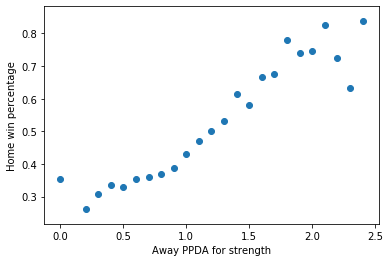

,FEATURE,TARGET_CLASS
FEATURE,1.000000,0.945897
TARGET_CLASS,0.945897,1.000000


In [1]:
#
# correlation analysis
#

import pyexasol
import pandas as pd
import matplotlib.pyplot as plt

dwh_host = 'ec2-18-198-93-169.eu-central-1.compute.amazonaws.com'
#dwh_host = 'ip-172-31-40-248.eu-central-1.compute.internal'
dwh_port = '8563'
dwh_user = 'sys'
dwh_pass = 'Kartoffelpuff3r'

v_sql = """SELECT 
	round(f.home_goals_for_STRENGTH,1) feature,
	avg(CASE WHEN s.HOME_GOALS > s.AWAY_GOALS THEN 1 ELSE 0 END) target_class
FROM 
	BETTING_DV.FOOTBALL_MATCH_HIS_B his
	JOIN BETTING_DV.FOOTBALL_MATCH_HIS_L_S_UNDERSTAT_TEAM_STRENGTH_FEATURES_EMA15_ha f
		ON his.FOOTBALL_MATCH_HIS_LID = f.FOOTBALL_MATCH_HIS_LID
	JOIN RAW_DV.FOOTBALL_MATCH_HIS_L_S_UNDERSTAT_TEAM_STATS s
		ON his.FOOTBALL_MATCH_HIS_LID = s.FOOTBALL_MATCH_HIS_LID
GROUP BY
	1
having
    count(*) > 20
ORDER BY 1;"""


#connect to db
dwh_conn = pyexasol.connect(dsn=dwh_host + ':' + dwh_port, user=dwh_user, password=dwh_pass)

pd_cor = dwh_conn.export_to_pandas(v_sql)

dwh_conn.close()

x = pd_cor.iloc[:,0]
y = pd_cor.iloc[:,1]

plt.scatter(x, y) 
plt.xlabel("Away PPDA for strength")
plt.ylabel("Home win percentage")
plt.show()

pd_cor.corr(method ='pearson')

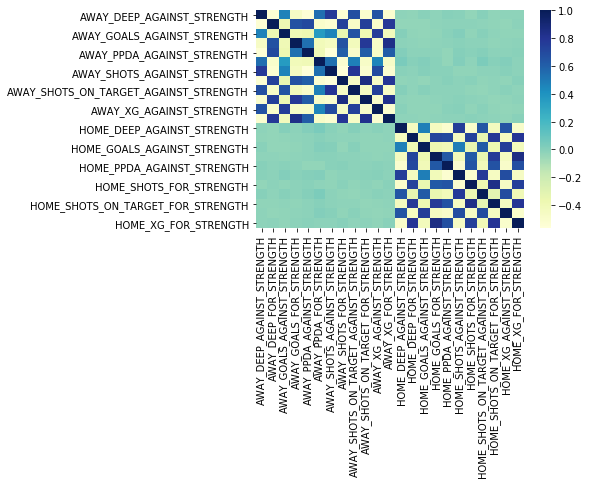

Top Absolute Correlations
AWAY_SHOTS_FOR_STRENGTH            AWAY_SHOTS_ON_TARGET_FOR_STRENGTH        0.861682
HOME_GOALS_FOR_STRENGTH            HOME_XG_FOR_STRENGTH                     0.855383
HOME_SHOTS_FOR_STRENGTH            HOME_SHOTS_ON_TARGET_FOR_STRENGTH        0.847080
AWAY_GOALS_FOR_STRENGTH            AWAY_XG_FOR_STRENGTH                     0.843879
AWAY_XG_FOR_STRENGTH               AWAY_SHOTS_ON_TARGET_FOR_STRENGTH        0.828667
HOME_XG_FOR_STRENGTH               HOME_SHOTS_ON_TARGET_FOR_STRENGTH        0.802895
AWAY_SHOTS_AGAINST_STRENGTH        AWAY_SHOTS_ON_TARGET_AGAINST_STRENGTH    0.798702
AWAY_XG_FOR_STRENGTH               AWAY_SHOTS_FOR_STRENGTH                  0.797893
HOME_XG_FOR_STRENGTH               HOME_DEEP_FOR_STRENGTH                   0.795950
HOME_SHOTS_ON_TARGET_FOR_STRENGTH  HOME_DEEP_FOR_STRENGTH                   0.784007
dtype: float64


In [7]:
#
# correlation analysis
#

import pyexasol
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from numpy.random      import randn
from pandas            import DataFrame
from seaborn           import heatmap
from matplotlib.pyplot import show
from itertools         import combinations

def absHighPass(df, absThresh):
    passed = set()
    for (r,c) in combinations(df.columns, 2):
        if (abs(df.loc[r,c]) >= absThresh):
            passed.add(r)
            passed.add(c)
    passed = sorted(passed)
    return df.loc[passed,passed]

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


dwh_host = 'ec2-18-198-93-169.eu-central-1.compute.amazonaws.com'
#dwh_host = 'ip-172-31-40-248.eu-central-1.compute.internal'
dwh_port = '8563'
dwh_user = 'sys'
dwh_pass = 'Kartoffelpuff3r'

v_sql = """-- BETTING_MART.UNDERSTAT_TEAM_MODEL_FEATURES_EMA15 source
SELECT	
	--model features
	f.HOME_GOALS_FOR_STRENGTH,
	f.HOME_GOALS_AGAINST_STRENGTH,
	f.HOME_XG_FOR_STRENGTH,
	f.HOME_XG_AGAINST_STRENGTH,
	f.HOME_SHOTS_FOR_STRENGTH,
	f.HOME_SHOTS_AGAINST_STRENGTH,
	f.HOME_SHOTS_ON_TARGET_FOR_STRENGTH,
	f.HOME_SHOTS_ON_TARGET_AGAINST_STRENGTH,
	f.HOME_PPDA_FOR_STRENGTH,
	f.HOME_PPDA_AGAINST_STRENGTH,
	f.HOME_DEEP_FOR_STRENGTH,
	f.HOME_DEEP_AGAINST_STRENGTH,
	f.AWAY_GOALS_FOR_STRENGTH,
	f.AWAY_GOALS_AGAINST_STRENGTH,
	f.AWAY_XG_FOR_STRENGTH,
	f.AWAY_XG_AGAINST_STRENGTH,
	f.AWAY_SHOTS_FOR_STRENGTH,
	f.AWAY_SHOTS_AGAINST_STRENGTH,
	f.AWAY_SHOTS_ON_TARGET_FOR_STRENGTH,
	f.AWAY_SHOTS_ON_TARGET_AGAINST_STRENGTH,
	f.AWAY_PPDA_FOR_STRENGTH,
	f.AWAY_PPDA_AGAINST_STRENGTH,
	f.AWAY_DEEP_FOR_STRENGTH,	
	f.AWAY_DEEP_AGAINST_STRENGTH
FROM 
	BETTING_DV.FOOTBALL_MATCH_HIS_B his
	JOIN BETTING_DV.FOOTBALL_MATCH_HIS_L_S_UNDERSTAT_TEAM_STRENGTH_FEATURES_EMA15_ha f
		ON his.FOOTBALL_MATCH_HIS_LID = f.FOOTBALL_MATCH_HIS_LID
	JOIN RAW_DV.FOOTBALL_MATCH_HIS_L_S_UNDERSTAT_TEAM_STATS s
		ON his.FOOTBALL_MATCH_HIS_LID = s.FOOTBALL_MATCH_HIS_LID
WHERE
	--features have to exist
	f.HOME_GOALS_FOR_STRENGTH IS NOT NULL AND
	f.HOME_SHOTS_FOR_STRENGTH IS NOT NULL and
	f.AWAY_GOALS_FOR_STRENGTH IS not NULL and
	f.AWAY_SHOTS_FOR_STRENGTH IS not NULL and
	--first season is skipped to have stable features
	his.SEASON <> '2014_2015';"""


#connect to db
dwh_conn = pyexasol.connect(dsn=dwh_host + ':' + dwh_port, user=dwh_user, password=dwh_pass)

pd_cor = dwh_conn.export_to_pandas(v_sql)

dwh_conn.close()

corrMatrix  = pd_cor.corr(method ='pearson')

#heatmap(corrDf,cmap="YlGnBu")
heatmap(absHighPass(corrMatrix,0.5),cmap="YlGnBu")
show()




print("Top Absolute Correlations")
print(get_top_abs_correlations(pd_cor, 10))

In [47]:
import pyexasol
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


dwh_host = 'ec2-18-198-93-169.eu-central-1.compute.amazonaws.com'
dwh_port = '8563'
dwh_user = 'sys'
dwh_pass = 'Kartoffelpuff3r'

v_sql = """-- BETTING_MART.UNDERSTAT_TEAM_MODEL_FEATURES_EMA15 source
SELECT	
	--model features
	f.HOME_GOALS_FOR_STRENGTH,
	f.HOME_GOALS_AGAINST_STRENGTH,
	f.HOME_XG_FOR_STRENGTH,
	f.HOME_XG_AGAINST_STRENGTH,
	f.HOME_SHOTS_FOR_STRENGTH,
	f.HOME_SHOTS_AGAINST_STRENGTH,
	f.HOME_SHOTS_ON_TARGET_FOR_STRENGTH,
	f.HOME_SHOTS_ON_TARGET_AGAINST_STRENGTH,
	f.HOME_PPDA_FOR_STRENGTH,
	f.HOME_PPDA_AGAINST_STRENGTH,
	f.HOME_DEEP_FOR_STRENGTH,
	f.HOME_DEEP_AGAINST_STRENGTH,
	f.AWAY_GOALS_FOR_STRENGTH,
	f.AWAY_GOALS_AGAINST_STRENGTH,
	f.AWAY_XG_FOR_STRENGTH,
	f.AWAY_XG_AGAINST_STRENGTH,
	f.AWAY_SHOTS_FOR_STRENGTH,
	f.AWAY_SHOTS_AGAINST_STRENGTH,
	f.AWAY_SHOTS_ON_TARGET_FOR_STRENGTH,
	f.AWAY_SHOTS_ON_TARGET_AGAINST_STRENGTH,
	f.AWAY_PPDA_FOR_STRENGTH,
	f.AWAY_PPDA_AGAINST_STRENGTH,
	f.AWAY_DEEP_FOR_STRENGTH,	
	f.AWAY_DEEP_AGAINST_STRENGTH,
	--target variables
	CASE WHEN s.HOME_GOALS > s.AWAY_GOALS THEN 1 ELSE 0 END home_win,
	CASE WHEN s.HOME_GOALS = s.AWAY_GOALS THEN 1 ELSE 0 END draw,
	CASE WHEN s.HOME_GOALS < s.AWAY_GOALS THEN 1 ELSE 0 END away_win
FROM 
	BETTING_DV.FOOTBALL_MATCH_HIS_B his
	JOIN BETTING_DV.FOOTBALL_MATCH_HIS_L_S_UNDERSTAT_TEAM_STRENGTH_FEATURES_EMA15_ha f
		ON his.FOOTBALL_MATCH_HIS_LID = f.FOOTBALL_MATCH_HIS_LID
	JOIN RAW_DV.FOOTBALL_MATCH_HIS_L_S_UNDERSTAT_TEAM_STATS s
		ON his.FOOTBALL_MATCH_HIS_LID = s.FOOTBALL_MATCH_HIS_LID
WHERE
	--features have to exist
	f.HOME_GOALS_FOR_STRENGTH IS NOT NULL AND
	f.HOME_SHOTS_FOR_STRENGTH IS NOT NULL and
	f.AWAY_GOALS_FOR_STRENGTH IS not NULL and
	f.AWAY_SHOTS_FOR_STRENGTH IS not NULL and
	--first season is skipped to have stable features
	his.SEASON <> '2014_2015';"""


#connect to db
dwh_conn = pyexasol.connect(dsn=dwh_host + ':' + dwh_port, user=dwh_user, password=dwh_pass)

pd_ft_imp = dwh_conn.export_to_pandas(v_sql)

dwh_conn.close()

pd_feature = pd_ft_imp.iloc[:,0:24]

pd_class = pd_ft_imp.iloc[:,24]


model=RandomForestClassifier()
model.fit(pd_feature,pd_class) 
feature_importances=pd.DataFrame({'features':pd_feature.columns,'feature_importance':model.feature_importances_})
feature_importances.sort_values('feature_importance',ascending=False)


,features,feature_importance
2,HOME_XG_FOR_STRENGTH,0.054875
15,AWAY_XG_AGAINST_STRENGTH,0.047638
14,AWAY_XG_FOR_STRENGTH,0.047627
0,HOME_GOALS_FOR_STRENGTH,0.047248
6,HOME_SHOTS_ON_TARGET_FOR_STRENGTH,0.046833
10,HOME_DEEP_FOR_STRENGTH,0.046748
9,HOME_PPDA_AGAINST_STRENGTH,0.043554
12,AWAY_GOALS_FOR_STRENGTH,0.043074
18,AWAY_SHOTS_ON_TARGET_FOR_STRENGTH,0.042816
13,AWAY_GOALS_AGAINST_STRENGTH,0.041884
